# Amplitude Modulation

Amplitude Modulation (AM) is the oldest form of radio modulation techniques.  The most primitive form of AM is "On-Off Keying," with the delightful acronym OOK.  In OOK, the signal is either there or it isn't: the amplitude is zero or one.  This is what's used in Morse code, where the message is encoded in a series of beeps and dead spaces.  A more sophisticated version of AM, with a less "binary" sort of amplitude, is used in "AM radio." This is commercial radio that's usually found in the region of 500~1500kHz.  Here in the US, it's used mostly for talk radio and sports broadcasts.

The principle behind AM is pretty easy to grasp: we generate a relatively high-frequency sine wave, and multiply its amplitude by our input signal.  This creates an "envelope" that matches up to our input signal:

In [1]:
%pylab inline
pylab.rcParams["figure.figsize"] = (15,5)

import scipy.signal

Populating the interactive namespace from numpy and matplotlib


In [2]:
Fs = 100000
Fc = 10000

t = np.arange(0, 0.0025, 1.0/Fs)

Fsignal = 1000

def cw(f, tcw = t, theta=0.0):
    "Generate a continuous wave (in I/Q) at the given frequency, over our time above"
    return np.exp(1.0j * (2.0*np.pi*tcw * f + theta))

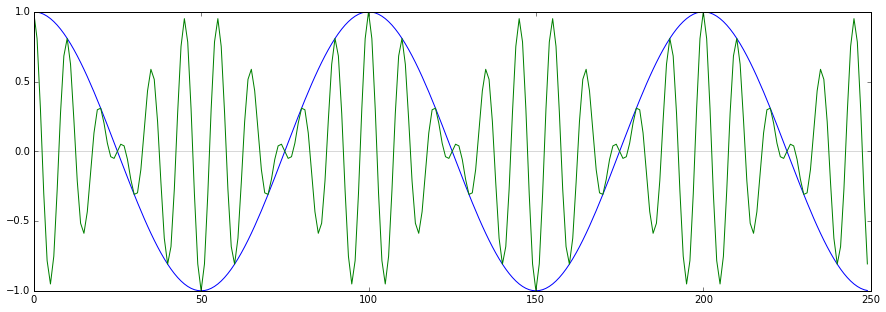

In [3]:
signal = cw(Fsignal)
plot(np.real(signal)); None

axhline(0, color="grey", alpha=0.3)

modulated = np.real(signal) * cw(Fc)
plot(np.real(modulated)); None

Note, though, that weird wibble as the signal line crosses zero.  We're allowing our input signal to have negative amplitudes, which is probably okay, but it makes life difficult.  Let's instead shift our signal up a bit, so that can't happen any more:

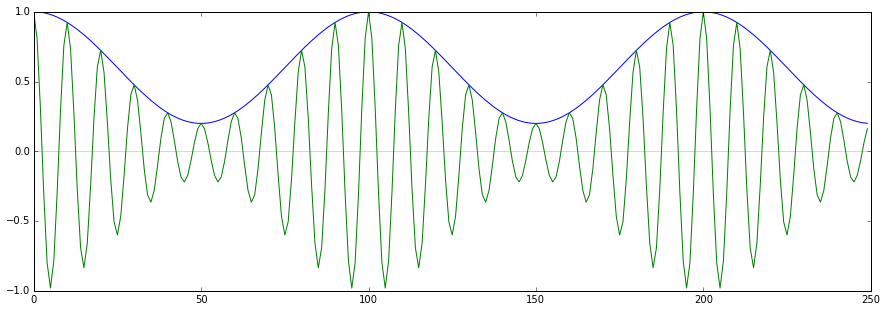

In [4]:
Fsignal = 1000
dc = 0.2
signal = 0.6 + 0.4 * cw(Fsignal)
plot(np.real(signal)); None

axhline(0, color="grey", alpha=0.3)

modulated = np.real(signal) * cw(Fc)
plot(np.real(modulated)); None

What if our input signal was more complicated?

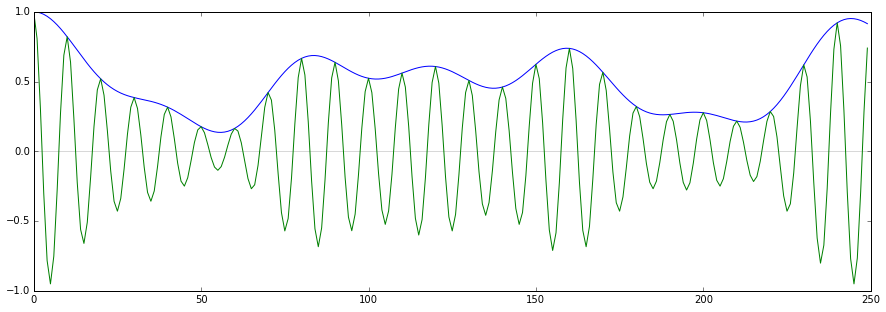

In [5]:
sig1 = cw(2500)
sig2 = cw(1200)
sig3 = cw(800)

signal = 0.5 + 0.1*sig1 + 0.2*sig2 + 0.2*sig3
plot(np.real(signal))

axhline(0, color="grey", alpha=0.3)

modulated = np.real(signal) * cw(Fc)
plot(np.real(modulated)); None

That's pretty easy, right?  Just multiply and Bob's your modulated uncle.  Let's see how this looks in the frequency domain, to see what's happening.  First, we'll want a longer version of this signal.  It helps the power spectrum distribution chart look a little clearer.

In [6]:
tlong = np.arange(0, 0.1, 1.0/Fs)

sig1 = cw(3000, tlong)
sig2 = cw(1200, tlong)
sig3 = cw(800, tlong)

signal = 0.5 + 0.1*sig1 + 0.2*sig2 + 0.2*sig3

modulated = np.real(signal) * cw(Fc, tlong)
len(modulated)

10000

Now that our signal is a bit longer, let's look at the Power Spectrum Distribution (PSD) of the signal.  This shows us how much power there is at various frequencies in the signal of interest.  We'll do one showing the overall signal, then zoom in a bit.

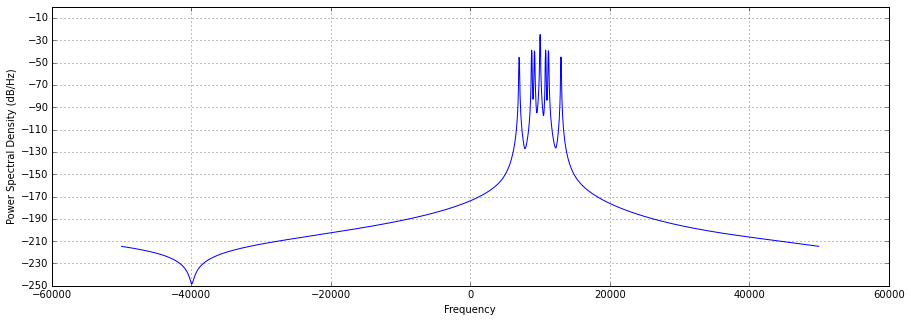

In [7]:
psd(modulated, NFFT=2048, Fs=Fs); None

As you can see, all our spectral content is at 10kHz, our carrier frequency.  There are some interesting spikes around it, though.  Let's look at those in more detail:

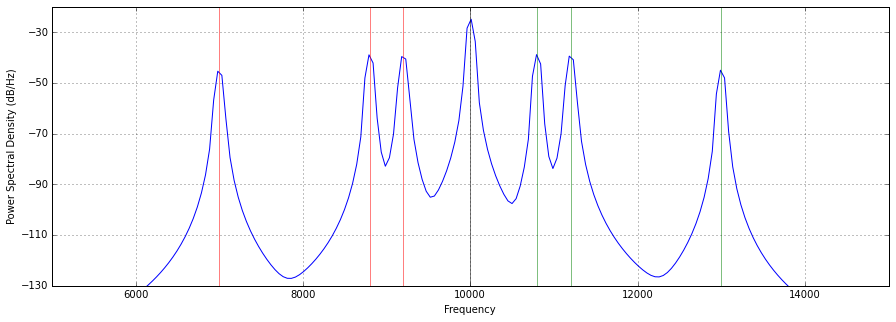

In [8]:
psd(modulated, NFFT=2048, Fs=Fs); None
xlim(Fc-5000,Fc+5000)
ylim(-130,-20)

axvline(Fc, color="black", alpha=0.5)
for df in [800,1200,3000]:
    axvline(Fc-df, color="red", alpha=0.5)
    axvline(Fc+df, color="green", alpha=0.5)

In the center of that image we find our carrier frequency, 10kHz.  There's a fair bit of power going into the carrier wave itself, which is unfortunate: that power isn't broadcasting any information!  Also unfortunate: our input signal shows up on both sides of the carrier, which means a 3kHz signal requires 6kHz of bandwidth to broadcast.  That is: naive AM wastes both power and bandwidth.  On the other hand, having that strong carrier signal is really helpful when trying to demodulate AM.  Once it's stripped out, receiving an AM signal is a lot fussier, which would have made the original AM receivers much more expensive.

In more modern variants of AM, both of these two problems are dealt with.  Many forms of AM are "suppressed carrier," which means that they don't broadcast that spike of power at the carrier frequency.  This puts all the broadcast power behind actual content, but makes the receivers markedly more complex.

There's another common optimization, as well.  Note that either side of the output signal is symmetrical.  This suggests that maybe one half of this signal is redundant, and could be cut out without losing any information.  This is actually possible, and is commonly done in ham radio: it's called SSB, "Single Side Band."  This halves the bandwidth required, and also halves the power required to transmit a given signal.  There are also many systems which retain both sidebands, and are called Double Side Band, DSB.

Let's look at demodulation now, and see where it gets tricky.

## AM Demodulation

The first modulation we can try is the simple one: just grab points at our carrier frequency:

In [9]:
# Generate a nice clean sine wave
Fsignal = 1000
dc = 0.2
signal = 0.6 + 0.4 * cw(Fsignal)

modulated = np.real(signal) * cw(Fc)

/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


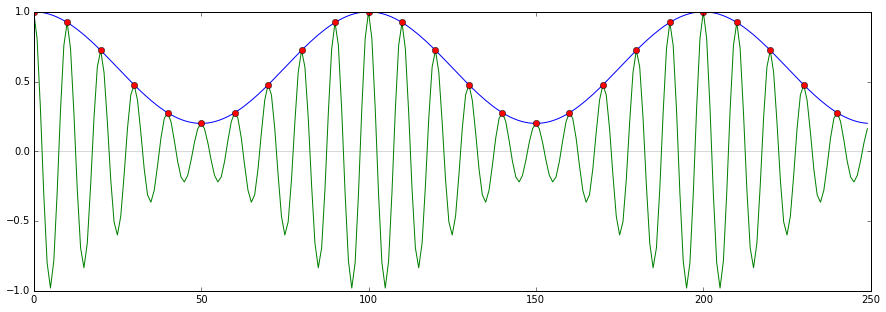

In [10]:
axhline(0, color="grey", alpha=0.3)

plot(np.real(signal)); None
plot(np.real(modulated)); None

# Let's just grab the point closest to our carrier frequency:
demod_times = np.round(np.arange(0, len(modulated), float(Fs)/Fc)).astype(int)
demod = modulated[demod_times]
plot(demod_times, demod, 'o', color="red")

"Well, hey, that was easy!  What's so bad about this?"

I know, right?  Let's try it again, with a tiny difference: instead of starting the demod at sample 0, let's go for sample 2.

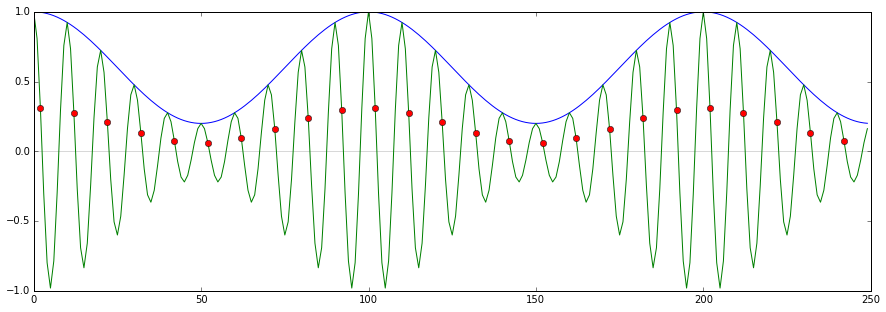

In [11]:
axhline(0, color="grey", alpha=0.3)

plot(np.real(signal)); None
plot(np.real(modulated)); None

# Let's just grab the point closest to our carrier frequency:
demod_times = np.round(np.arange(2, len(modulated), float(Fs)/Fc)).astype(int)
demod = modulated[demod_times]
plot(demod_times, demod, 'o', color="red")

See what happened there?  We slipped in phase, and that means we sampled the carrier at a much lower amplitude.  When we demodulate AM in this sort of fashion, we really need to know that we're in-phase with it.

What if we tried a different trick, and just downmixed the signal?  That is, what if we multiply it by a carrier to get our original signal out?

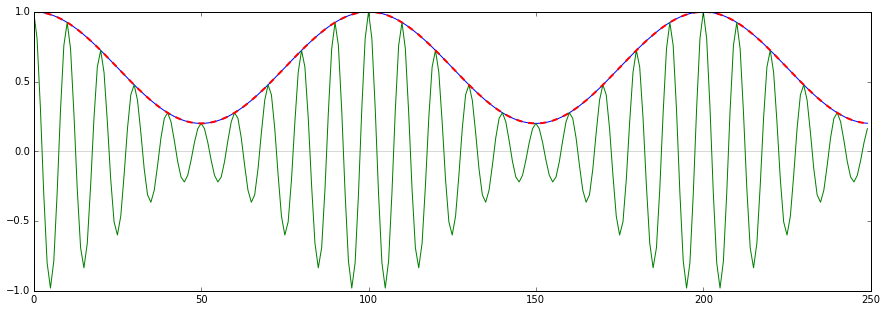

In [12]:
axhline(0, color="grey", alpha=0.3)

plot(np.real(signal)); None
plot(np.real(modulated)); None

# Let's just grab the point closest to our carrier frequency:
demod_carrier = cw(-Fc)

demod = demod_carrier * modulated
plot(demod, "--", color="red", linewidth=2)

Ah, that's also trivial, right!  Does it have the same offset problem, though?  Let's add a small phase shift to our demodulation waveform, and see:

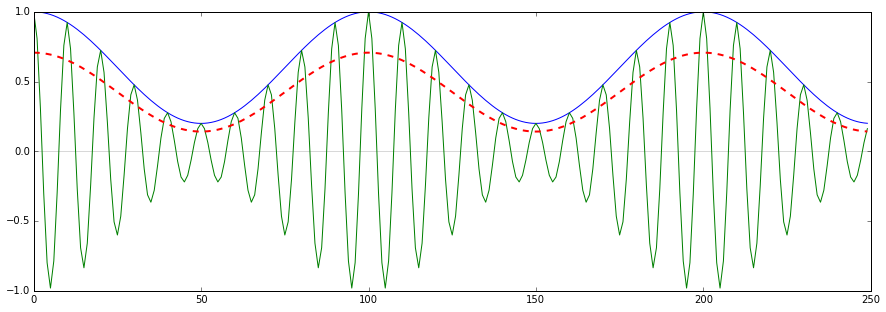

In [13]:
axhline(0, color="grey", alpha=0.3)

plot(np.real(signal)); None
plot(np.real(modulated)); None

# Let's just grab the point closest to our carrier frequency:
demod_carrier = cw(-Fc, theta=np.pi/4)

demod = demod_carrier * modulated
plot(demod, "--", color="red", linewidth=2)

As you can see, these trivial forms of AM demodulation really need to get the phase right.  Happily, since this signal is DSB-AM (i.e. it has the carrier intact), we just need to re-extract the carrier and use that.  We can do this pretty easily with a very narrow filter.  Let's first try to recover the carrier signal.

(5000, 15000)

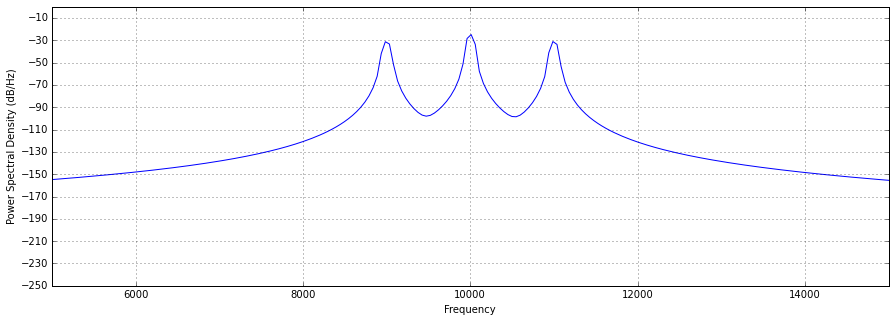

In [14]:
# We're going to use rather long filters, so let's give ourselves lots of rope
tlong = np.arange(100000)/float(Fs) # 100k samples should do

signal = 0.5+0.5*cw(Fsignal, tlong)
modulated = np.real(signal) * cw(Fc, tlong)
psd(modulated, NFFT=2048, Fs=Fs); None
xlim(5000,15000)

Now, let's filter down to just that spike in the center.

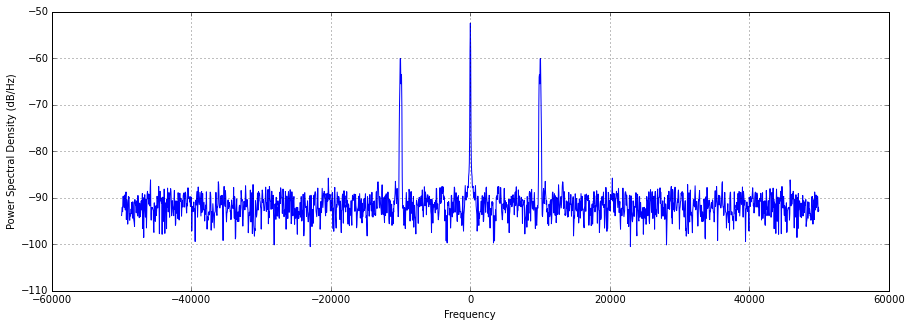

In [15]:
xwidth = 100 # half the width of our bandpass filter
delay = 555 # number of samples of delay we want
bpf_carrier = 0.0j + scipy.signal.remez(2*delay+1,
                                 [0,Fc-2*xwidth, Fc-xwidth,Fc+xwidth, Fc+2*xwidth,Fs/2],
                                 [ 0,            1,            0],
                                 Hz=Fs)

noise = numpy.random.uniform(size=10000)
psd(scipy.signal.lfilter(bpf_carrier, 1.0, noise), NFFT=2048, Fs=Fs); None

That looks like a reasonably narrow filter.  Let's run it against our modulated signal and see what we get.  Note that our plot below skips the first bunch of samples: until our filter has a full $\mathrm{delay}$ samples to work with, its output will be bogus.  So, we just skip ahead a bit to get to the good data.

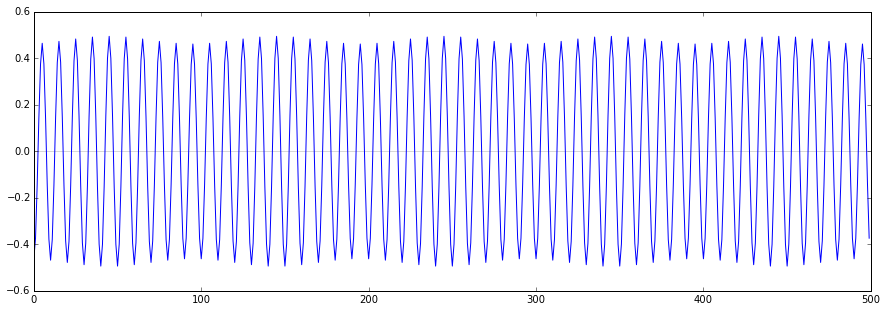

In [16]:
carrier_filtered = scipy.signal.lfilter(bpf_carrier, 1.0, modulated)

axhline(0, color="grey", alpha=0.3)
plot(carrier_filtered[2*delay:(2*delay+500)]); None

So, now we've got the carrier signal extracted nicely.  Let's double-check our phase before we do anything else:

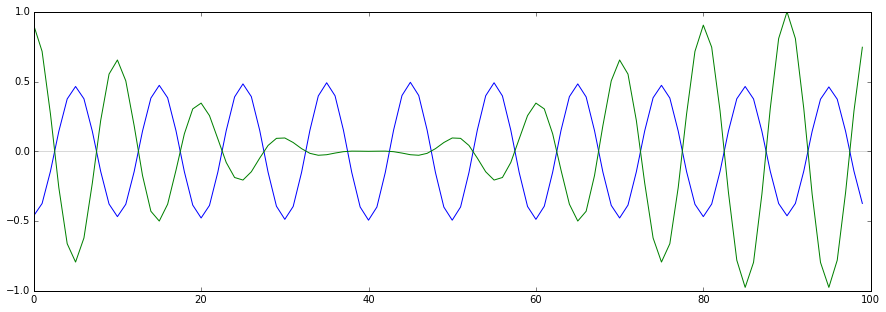

In [17]:
axhline(0, color="grey", alpha=0.3)

i0 = delay*2+100

plot(np.real(carrier_filtered[i0:(i0+100)]))
plot(np.real(modulated[i0:(i0+100)]))

That's not right: it turns out that we're going to get some phase offset due to the way the filter works.  To correct for this, we need to slide the signals around a bit:

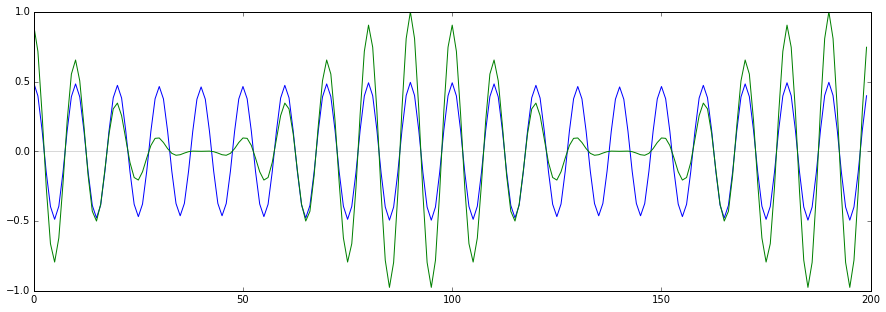

In [18]:
axhline(0, color="grey", alpha=0.3)

l=200

i0 = 3*delay
i1 = i0+l

i0d = i0 - delay # the filter is delayed, so go back in the original signal
i1d = i0d + l

plot(np.real(carrier_filtered[i0:i1]))
plot(np.real(modulated[i0d:i1d]))

So, we need to move things around by a little bit to get everything lined up.  If this was a flowgraph sort of setup, we would add a delay line that's $\mathrm{delay}$ samples long  In our case, we'll just cut out subsections and work from there.

Also worth note: the carrier we're extracting is an I/Q signal at 10kHz.  For our mixing to work cleanly here, we want a signal at -10kHz.  Thankfully, that's as simple as taking the complex conjugate of our signal, which reverses the direction of spin.

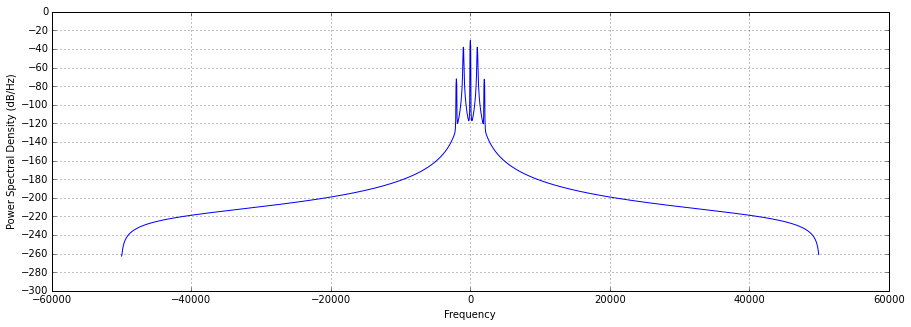

In [19]:
i0 = 3*delay

carrier_extracted = carrier_filtered[i0:]
modulated_extracted = modulated[i0-delay:-delay]

demod = modulated_extracted * np.conj(carrier_extracted)
t psd(demod, NFFT=2048, Fs=Fs); None

The spectrum looks pretty reasonable; let's look at the signal itself:

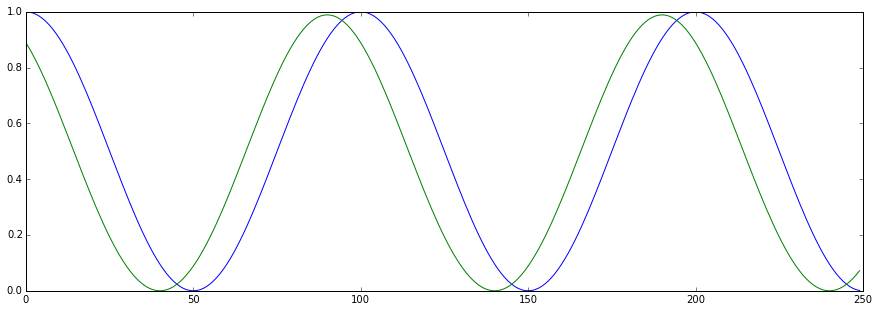

In [33]:
plot(signal[0:250])
plot(demod[0:250]*2)

Ignoring the little "times two" that snuck into our plotting of the demodulated signal, that looks pretty great!  We've also got a phase delay here, but that doesn't much matter at this point.

So, we've now figured out how to demodulate DSB-AM content, which is fantastic!  We're going to need to know how to do that once we try to do stereo FM.  Commercial FM manages to get stereo audio by slipping an AM version of the left channel minus the right channel into  the signal that gets frequency modulated.  If we want to get stereo audio, we have to do some AM demodulation.

## Problems

One thing we didn't touch on here is frequency drift.  What happens if the clock that provides our carrier frequency isn't quite right?  For instance, if we expect the signal to be at 10kHz, but accidentally downmix it to 10,100Hz, what happens to the signal?  Feel free to cheat and use one of the slightly janky demodulation methods to get an intuition about it.

For all-digital prototypes, what are the advantages and disadvantages of using the more correct demodulation techniques instead of the quick ones?  When is it appropriate to cut that corner?  When is it best not to?

One problem in the real world is path fading: the amplitude of your signal will vary over time due to changing atmospheric conditions, the user driving around, etc.  The usual solution to this is AGC, Automatic Gain Control.  In general, the amount of power contained in that carrier wave should be constant.  How could you use that fact to ensure the amplitude of the overall system remains relatively constant with these changes?

We used I/Q signals throughout this example, which gave us DSB-AM signals.  If you re-run them with simple real-valued oscillators (i.e. replace $\mathtt{np.exp(1.0j *\dots) }$ with $\mathtt{np.cos(\dots)}$ in the cw() function), you should get DSB-SC signals.  How does this affect things above?